In [1]:
import mlforecast

In [2]:
import pandas as pd

In [3]:
import glob

In [4]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 300)

In [5]:
import warnings
warnings.filterwarnings('ignore')

## Import data

In [6]:
data_path = 'dataset'

In [7]:
data_list = glob.glob(f'{data_path}/*.csv')

In [8]:
data_list

['dataset/VIC.csv', 'dataset/MSN.csv', 'dataset/PNJ.csv', 'dataset/FPT.csv']

In [9]:
from pathlib import Path
stock_list = [Path(i).stem for i in data_list]

In [10]:
stock_list

['VIC', 'MSN', 'PNJ', 'FPT']

In [11]:
result = {}
for data, stock in zip(data_list, stock_list):
    result[stock] = pd.read_csv(data)

In [12]:
from datetime import datetime as dt
def format_dt(row):
    row = dt.strptime(row, '%m/%d/%Y %H:%M')
    return row
    
for df in result.values():
    df['datetime'] = df['Date/Time'].apply(lambda row: format_dt(row))
    df['date'] = df['datetime'].apply(lambda row: row.date())
    df['time'] = df['datetime'].apply(lambda row: row.time())
    df['date_fmt'] = df['date'].apply(lambda row: dt.strptime(str(row),'%Y-%m-%d'))

In [13]:
def generate_target(i):
    i['close_shift1'] = i['Close'].shift(-1)
    i['target'] = (i['close_shift1'] - i['Close'])/i['Close']
    return i

In [14]:
result_byDate = {}

In [15]:
for stock, df in result.items():
    df_byDate = df.groupby(['Ticker', 'date','date_fmt']).agg(
        {'Open':'first',
        'High':'max',
        'Low':'min',
        'Close':'last',
        'Volume':'sum'}
    )
    df_byDate.reset_index(inplace=True)
    df_byDate = generate_target(df_byDate)
    result_byDate[stock] = df_byDate

In [16]:
result_byDate['FPT']

,Ticker,date,date_fmt,Open,High,Low,Close,Volume,close_shift1,target
0,FPT,2018-12-25,2018-12-25,30.89,30.89,30.59,30.66,84960,30.89,0.007502
1,FPT,2018-12-26,2018-12-26,31.04,31.22,30.89,30.89,333590,31.19,0.009712
2,FPT,2018-12-27,2018-12-27,31.41,31.52,31.19,31.19,454860,31.49,0.009618
3,FPT,2018-12-28,2018-12-28,31.34,31.49,31.19,31.49,387170,30.74,-0.023817
4,FPT,2019-01-02,2019-01-02,31.19,31.45,30.70,30.74,459120,30.44,-0.009759
...,...,...,...,...,...,...,...,...,...,...
494,FPT,2020-12-16,2020-12-16,57.20,57.50,57.00,57.10,1995530,56.50,-0.010508
495,FPT,2020-12-17,2020-12-17,56.90,57.00,56.00,56.50,3594500,56.90,0.007080
496,FPT,2020-12-18,2020-12-18,56.50,57.00,56.50,56.90,1532820,57.50,0.010545
497,FPT,2020-12-21,2020-12-21,57.30,57.80,57.10,57.50,2307390,58.10,0.010435


In [17]:
lookup = dt.strptime('2018-10-17','%Y-%m-%d').date()

## EDA

In [18]:
print('Training data dựa trên 4 mã cổ phiếu {}'.format(list(result_byDate.keys())))

Training data dựa trên 4 mã cổ phiếu ['VIC', 'MSN', 'PNJ', 'FPT']


In [19]:
for stock, df_stock in result_byDate.items():
    print(stock)
    print('Bắt đầu: ',df_stock.date.min(), 'Kết thúc: ', df_stock.date.max()) 

VIC
Bắt đầu:  2018-10-17 Kết thúc:  2020-12-22
MSN
Bắt đầu:  2017-12-25 Kết thúc:  2020-12-22
PNJ
Bắt đầu:  2018-02-28 Kết thúc:  2020-12-22
FPT
Bắt đầu:  2018-12-25 Kết thúc:  2020-12-22


In [20]:
for stock, df_stock in result_byDate.items():
    print(stock)
    display(df_stock.describe().style.format('{:,.2f}'))

VIC


,date_fmt,Open,High,Low,Close,Volume,close_shift1,target
count,548.00,548.00,548.00,548.00,548.00,548.00,547.00,547.00
mean,",.2f",105.95,106.93,104.86,106.06,"588,126.24",106.08,0.00
min,",.2f",71.50,75.00,68.00,71.50,"90,450.00",71.50,-0.07
25%,",.2f",96.00,96.78,94.90,96.00,"306,160.00",96.00,-0.01
50%,",.2f",105.80,106.90,104.60,105.80,"485,805.00",105.80,0.00
75%,",.2f",116.00,116.60,115.10,115.93,"763,432.50",115.95,0.00
max,",.2f",126.10,126.50,124.60,126.10,"2,855,700.00",126.10,0.07
std,nan,11.51,11.28,11.64,11.39,"390,843.58",11.40,0.02


MSN


,date_fmt,Open,High,Low,Close,Volume,close_shift1,target
count,748.00,748.00,748.00,748.00,748.00,748.00,747.00,747.00
mean,",.2f",76.18,77.31,75.14,76.28,"1,028,469.22",76.28,0.00
min,",.2f",46.50,49.00,46.40,49.00,"57,480.00",49.00,-0.07
25%,",.2f",61.50,62.75,60.50,61.98,"442,827.50",61.95,-0.01
50%,",.2f",80.00,81.20,79.00,80.12,"744,850.00",80.14,0.00
75%,",.2f",86.50,87.90,85.60,86.86,"1,218,397.50",86.86,0.01
max,",.2f",115.00,118.00,113.00,114.60,"6,707,870.00",114.60,0.07
std,nan,14.88,15.07,14.59,14.82,"971,589.24",14.83,0.02


PNJ


,date_fmt,Open,High,Low,Close,Volume,close_shift1,target
count,709.00,709.00,709.00,709.00,709.00,709.00,708.00,708.00
mean,",.2f",72.39,74.06,71.33,72.41,"535,847.17",72.40,0.00
min,",.2f",45.10,48.74,44.04,45.90,"8,158.00",45.90,-0.08
25%,",.2f",66.12,67.93,65.25,66.10,"277,900.00",66.07,-0.01
50%,",.2f",72.72,74.45,71.86,72.72,"443,090.00",72.69,0.00
75%,",.2f",80.25,82.00,79.18,80.40,"709,350.00",80.40,0.01
max,",.2f",98.50,100.16,95.37,98.90,"2,362,950.00",98.90,0.07
std,nan,9.68,10.06,9.51,9.64,"383,870.24",9.64,0.02


FPT


,date_fmt,Open,High,Low,Close,Volume,close_shift1,target
count,499.00,499.00,499.00,499.00,499.00,499.00,498.00,498.00
mean,",.2f",44.30,44.76,43.91,44.33,"1,570,241.84",44.36,0.00
min,",.2f",30.29,30.89,30.22,30.44,"84,960.00",30.44,-0.07
25%,",.2f",38.26,38.59,37.90,38.09,"920,685.00",38.13,-0.01
50%,",.2f",46.50,47.00,46.09,46.52,"1,339,560.00",46.53,0.00
75%,",.2f",49.00,49.50,48.57,49.08,"2,004,005.00",49.08,0.01
max,",.2f",57.50,58.50,57.20,58.10,"6,853,810.00",58.10,0.07
std,nan,6.77,6.82,6.69,6.76,"953,078.07",6.74,0.02


In [21]:
from matplotlib import pyplot as plt
import seaborn as sns

In [22]:
def quick_eda(stock):
    df_plot = result_byDate[stock]
    plt.figure(figsize=(13, 15))
    plt.subplot(4, 1, 1)
    sns.lineplot(data=df_plot, x=df_plot.date, y="Close", label="Close")
    plt.title("Close Prices {}".format(stock))
    plt.xlabel("Date/Time")
    plt.ylabel("Price ($)")
    plt.xticks(rotation=45)
    
    plt.subplot(4, 1, 2)
    sns.lineplot(data=df_plot, x=df_plot.date, y="target", label="Target")
    plt.title("Price chanage {}".format(stock))
    plt.xlabel("Date/Time")
    plt.ylabel("%change")
    plt.xticks(rotation=45)

    plt.subplot(4, 1, 3)
    sns.histplot(data=df_plot.target, bins=50)
    plt.title("Return distribution {}".format(stock))
    plt.xlabel("return")
    plt.xticks(rotation=45)
    
    plt.subplot(4, 1, 4)
    sns.lineplot(data=df_plot, x=df_plot.date, y="Volume", label="Volume")
    plt.title("Volume {}".format(stock))
    plt.xlabel("Date/Time")
    plt.ylabel("Volume")
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

In [23]:
result_byDate.keys()

dict_keys(['VIC', 'MSN', 'PNJ', 'FPT'])

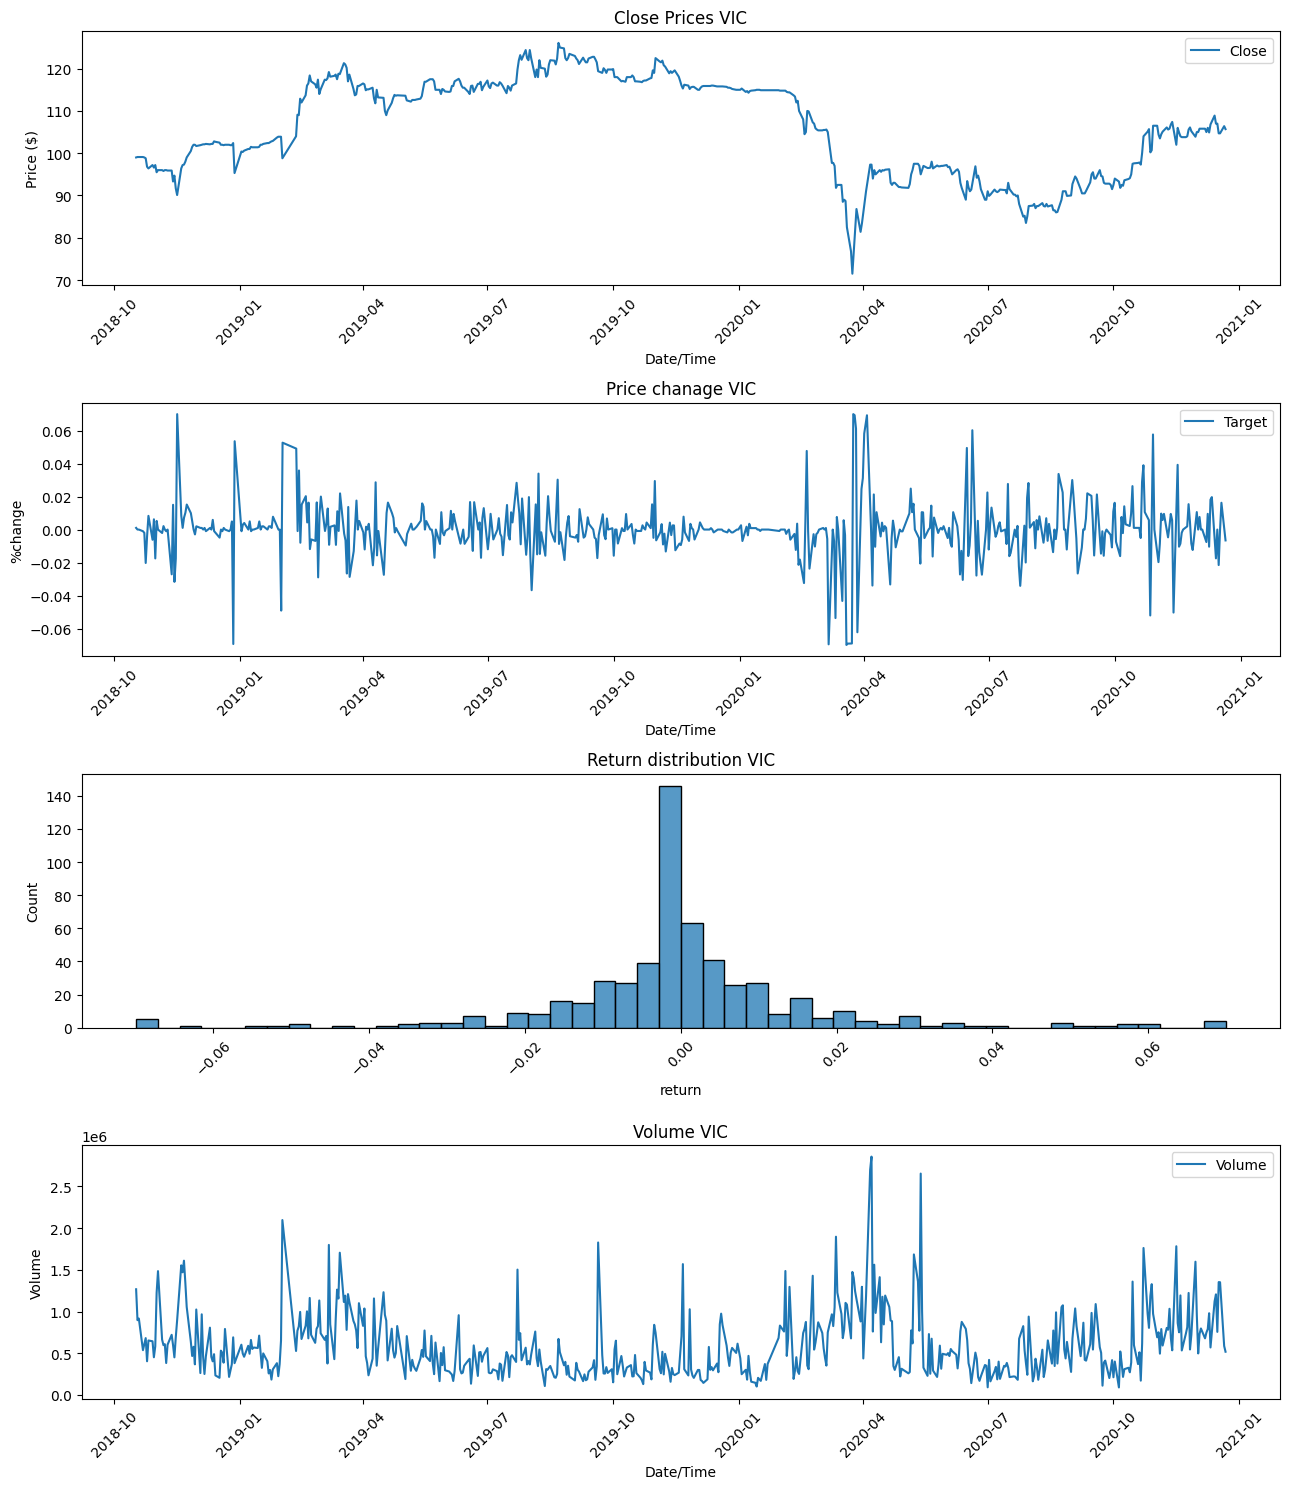

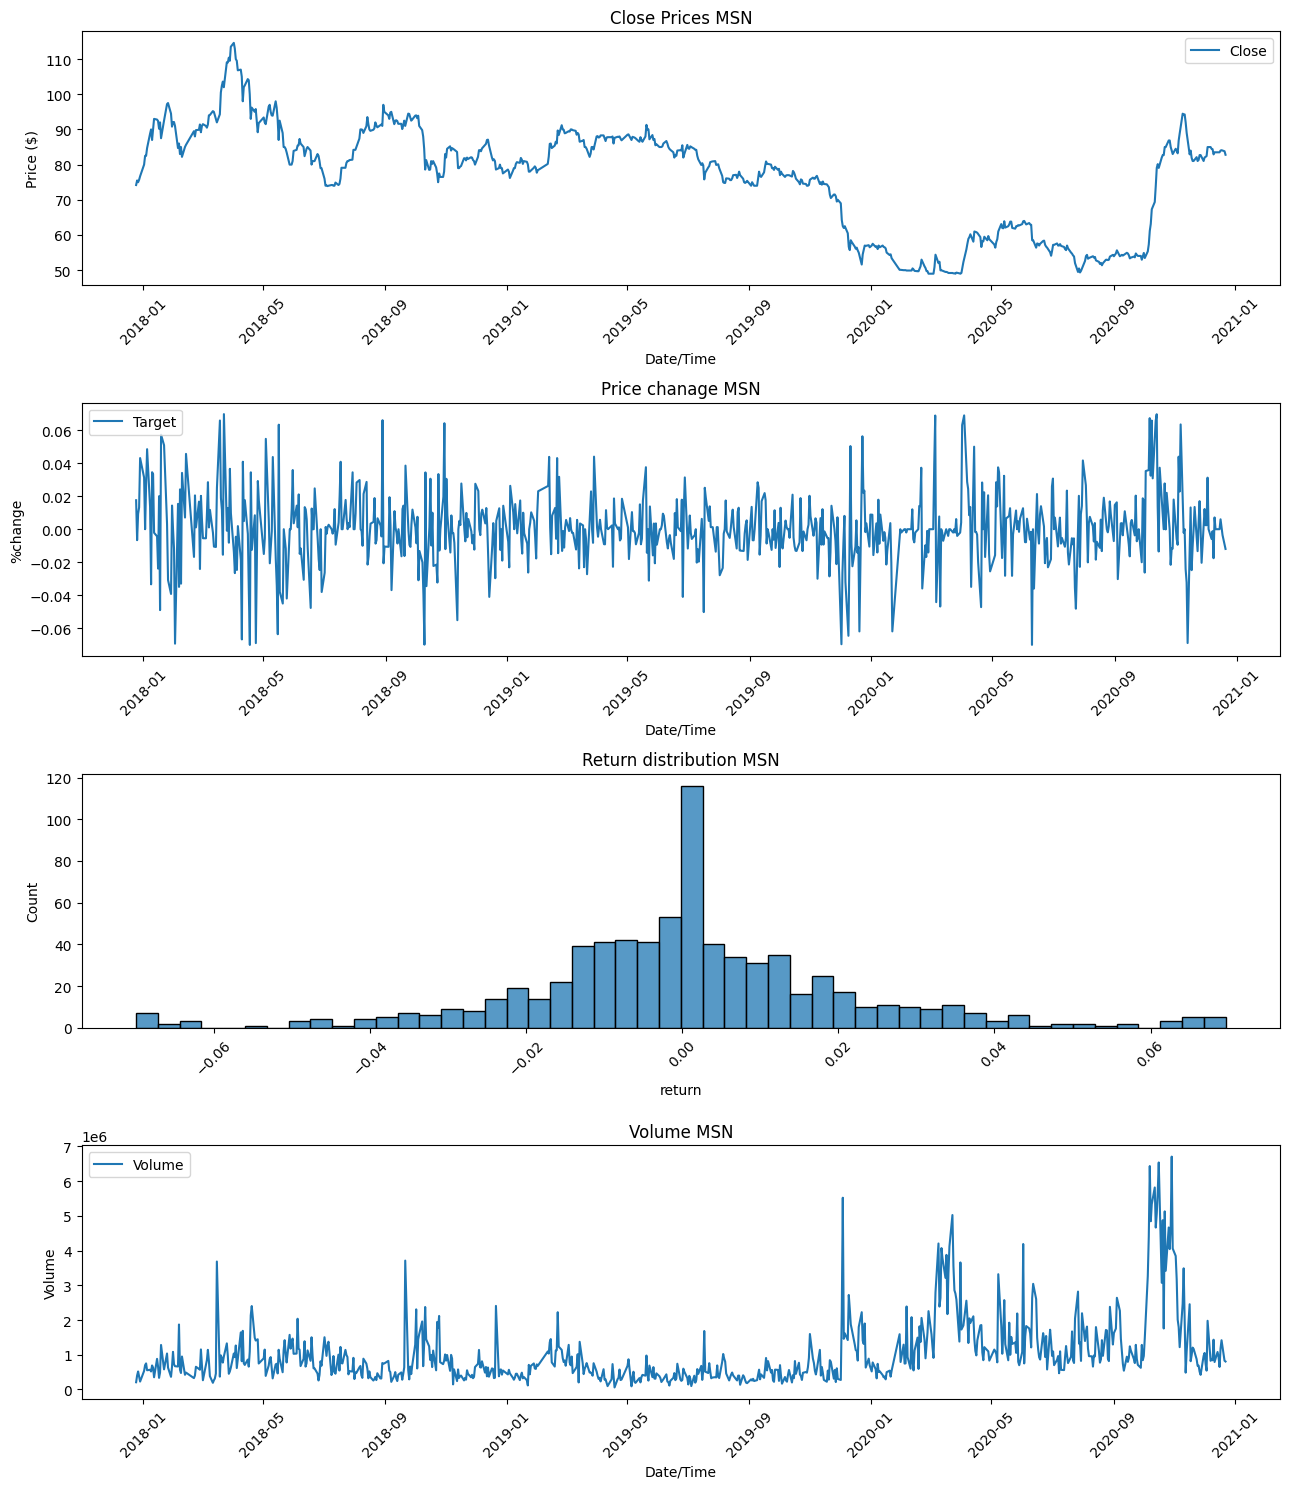

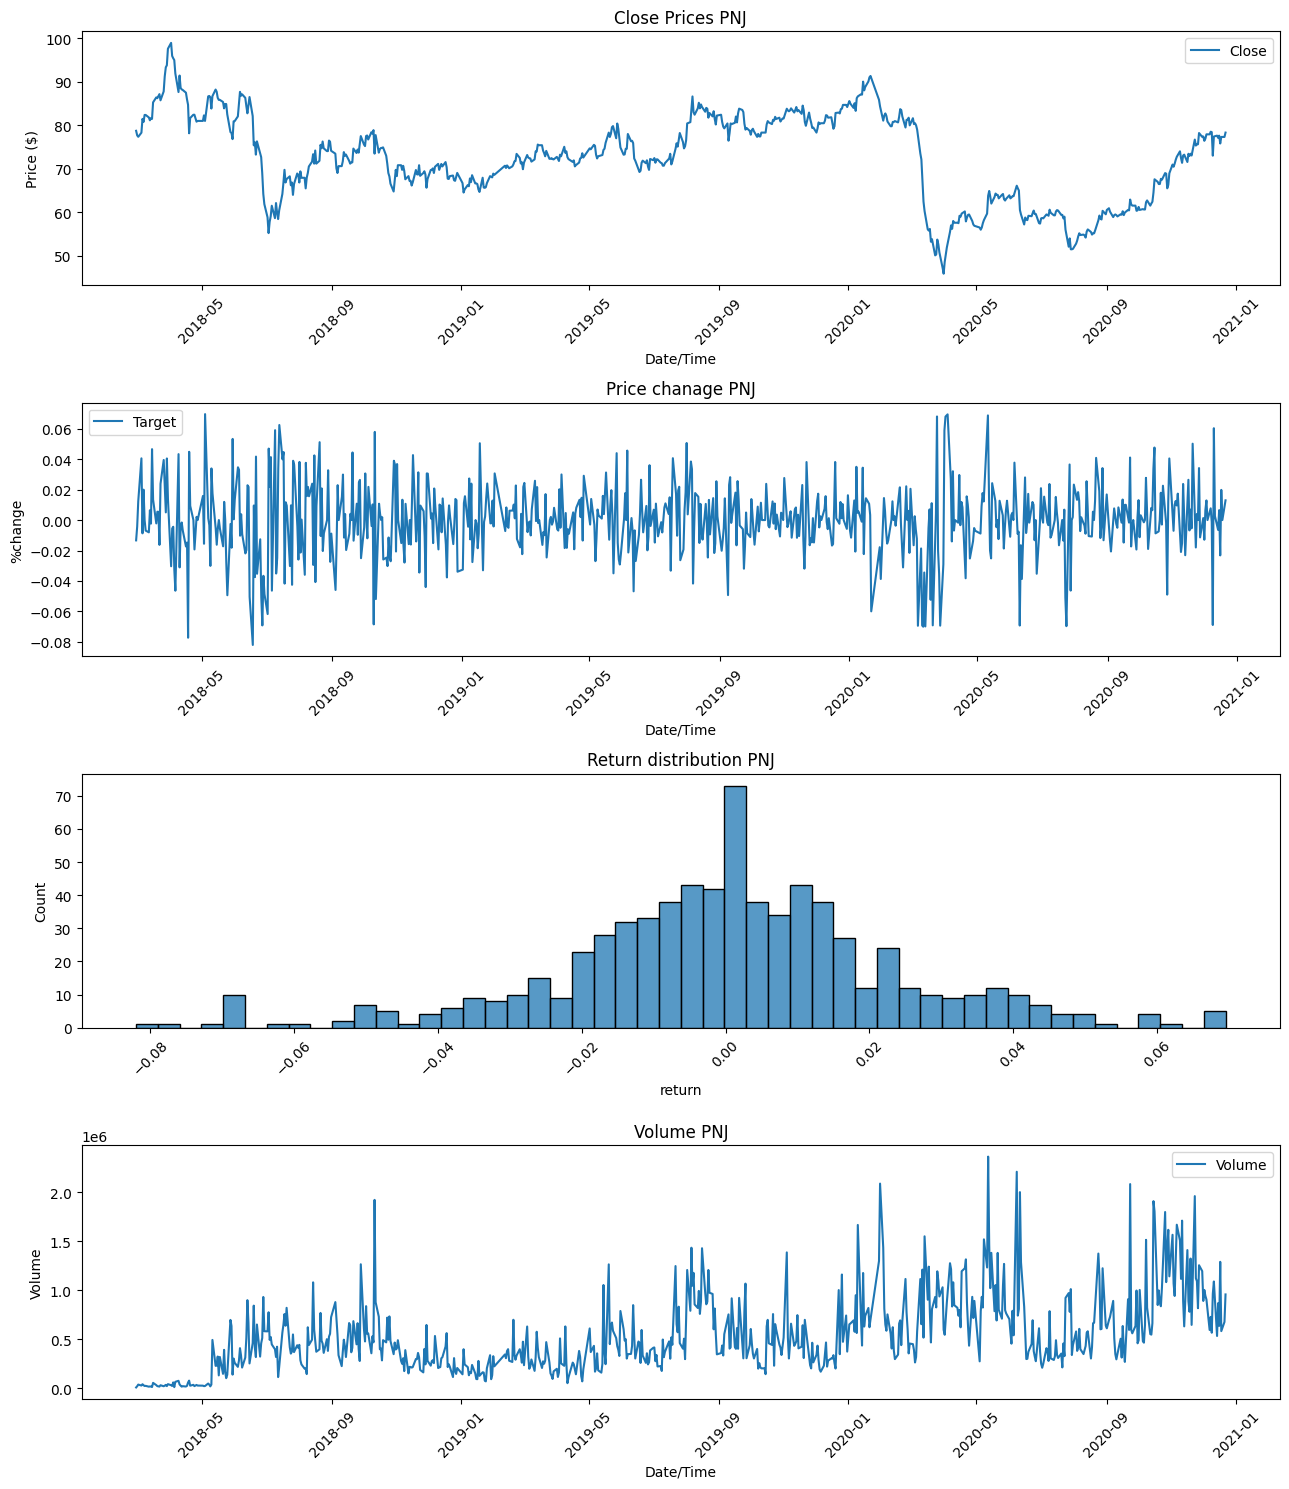

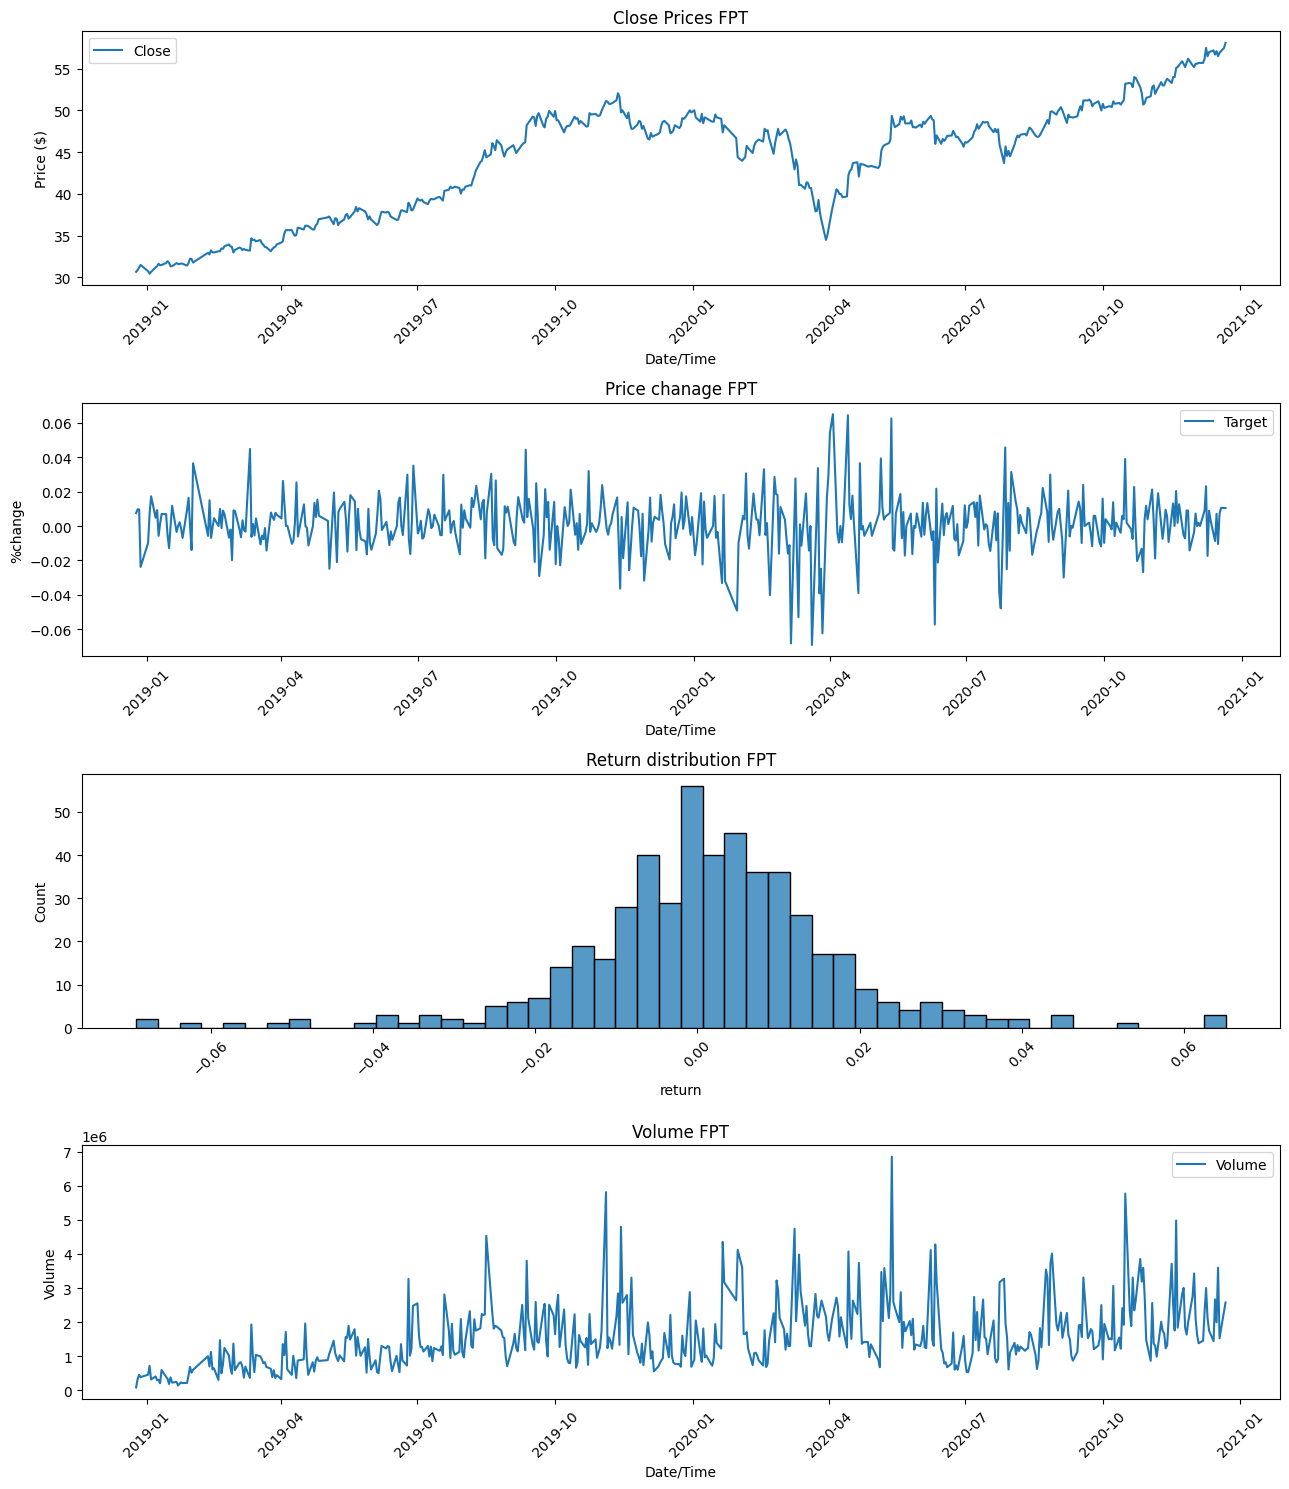

In [24]:
for i in result_byDate.keys():
    quick_eda(i)

## Feature engineer

Stock price moving average, exponential moving average, return, and volatility, each over a period of 5, 10, 20, 30, and 50 days

In [25]:
import mlforecast
import numpy as np
import pandas as pd
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean, RollingStd

In [26]:
fcst = MLForecast(
    models=[],
    freq='D',
    lags=[7 * (i+1) for i in range(8)],
    lag_transforms = {
        1:  [ExpandingMean()],
        1:  [RollingMean(7), RollingMean(14), RollingMean(28), RollingStd(30)], 
        7:  [RollingMean(7), RollingMean(14), RollingMean(28), RollingStd(30)], # 7-day moving average for 7-day lags
        14: [RollingMean(7), RollingMean(14), RollingMean(28), RollingStd(30)], 
        28: [RollingMean(7), RollingMean(14), RollingMean(28), RollingStd(30)],
        50: [RollingMean(7), RollingMean(14), RollingMean(28), RollingStd(30)],
    },
    date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week'], # Xét các ngày để tính đến yếu tố có thể ảnh hưởng đến giá. Ví dụ báo cáo tài chính quý etc.
    num_threads=4,
)

In [ ]:
result_byDate['FPT']

In [ ]:
df_input = result_byDate['FPT'][['Ticker', 'date_fmt', 'target',
                                'Open',	'High',	'Low',	'Close', 'Volume']]
df_input = df_input.rename(columns={'Ticker':'unique_id', 
                         'date_fmt':'ds', 
                         'target':'y'
                        }
               )
df_input = df_input[~df_input['y'].isna()]

In [ ]:
len(result_byDate['FPT'])

In [ ]:
df_feature = fcst.preprocess(df_input, 
                            id_col='unique_id',
                            time_col='ds',
                            target_col='y',
                            static_features=[])

In [ ]:
df_feature.info()

## Stationary test

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight') 
# import matplotlib as mpl
import seaborn as sns   

In [ ]:
result_byDate.keys()

In [ ]:
for i in result_byDate.keys():
    print(i)
    df_plot = result_byDate[i].copy()
    df_plot = df_plot[~df_plot["target"].isna()]
    decomposition = sm.tsa.seasonal_decompose(df_plot["target"],period =12) 
    figure = decomposition.plot()
    
    plt.show()

In [ ]:
result = adfuller(df_plot['target'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [ ]:
result = adfuller(df_plot['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [ ]:
decomposition = seasonal_decompose(df_plot['target'], model='additive', period =12)

In [ ]:
result = adfuller(decomposition.trend[10:-10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
result = adfuller(decomposition.seasonal[10:-10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
result = adfuller(decomposition.resid[10:-10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

## Training and evaluation

In [27]:
import lightgbm as lgb
from utilsforecast.plotting import plot_series
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [28]:
import mlforecast
import numpy as np
import pandas as pd
from mlforecast import MLForecast
from mlforecast.core import TimeSeries
from mlforecast.lag_transforms import ExpandingMean, RollingMean, SeasonalRollingMean

In [29]:
params = {
    'verbose': -1,
    'learning_rate':0.1,
    'num_leaves': 5,
    'n_estimators': 30,
}

fcst = MLForecast(
    models=[lgb.LGBMRegressor(**params)],
    freq='1d',
    lags=[7 * (i+1) for i in range(8)],
    lag_transforms = {
        1:  [ExpandingMean()],
        1:  [RollingMean(7), RollingMean(14), RollingMean(28), SeasonalRollingMean(7, 4)], 
        7:  [RollingMean(7), RollingMean(14), RollingMean(28), SeasonalRollingMean(7, 4)], # 7-day moving average for 7-day lags
        14: [RollingMean(7), RollingMean(14), RollingMean(28), SeasonalRollingMean(7, 4)], 
        28: [RollingMean(7), RollingMean(14), RollingMean(28), SeasonalRollingMean(7, 4)],
    },
    date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week'],    
    num_threads=4
)

In [30]:
result_byDate_feat = {}
for stock, df_input in result_byDate.items():
    df_input = result_byDate[stock]
    df_input = df_input[~df_input['target'].isna()]
    df_input.rename(columns={'Ticker':'unique_id','date_fmt':'ds','target':'y'}, inplace=True)
    id_col_lst = ['unique_id','ds','y']
    df_process = fcst.preprocess(df_input, static_features=[])
    result_byDate_feat[stock] = df_process

feat_list = list(set(df_process.columns) - set(id_col_lst))

In [31]:
result_byDate['FPT'].head(2)

,Ticker,date,date_fmt,Open,High,Low,Close,Volume,close_shift1,target
0,FPT,2018-12-25,2018-12-25,30.89,30.89,30.59,30.66,84960,30.89,0.007502
1,FPT,2018-12-26,2018-12-26,31.04,31.22,30.89,30.89,333590,31.19,0.009712


In [32]:
df_feature = result_byDate_feat['FPT']

In [33]:
df_feature.head(2)

,unique_id,date,ds,Open,High,Low,Close,Volume,close_shift1,y,lag7,lag14,lag21,lag28,lag35,lag42,lag49,lag56,rolling_mean_lag1_window_size7,rolling_mean_lag1_window_size14,rolling_mean_lag1_window_size28,seasonal_rolling_mean_lag1_season_length7_window_size4,rolling_mean_lag7_window_size7,rolling_mean_lag7_window_size14,rolling_mean_lag7_window_size28,seasonal_rolling_mean_lag7_season_length7_window_size4,rolling_mean_lag14_window_size7,rolling_mean_lag14_window_size14,rolling_mean_lag14_window_size28,seasonal_rolling_mean_lag14_season_length7_window_size4,rolling_mean_lag28_window_size7,rolling_mean_lag28_window_size14,rolling_mean_lag28_window_size28,seasonal_rolling_mean_lag28_season_length7_window_size4,year,month,day,dayofweek,quarter,week
56,FPT,2019-03-22,2019-03-22,33.65,33.87,33.61,33.61,687690,33.13,-0.014281,0.001160,-0.002085,0.008977,0.014962,-0.006955,-0.012913,0.004809,0.007502,-0.003591,0.000168,0.000987,-0.000003,0.004391,0.001752,0.003452,0.005753,-0.000888,0.000589,0.002438,0.003724,0.008240,0.004287,0.002689,-0.000024,2019,3,22,4,1,12
57,FPT,2019-03-25,2019-03-25,32.98,33.57,32.98,33.13,633520,33.39,0.007848,-0.005506,-0.006567,0.006821,-0.006919,0.009551,0.000000,0.009253,0.009712,-0.005797,-0.000703,-0.000057,-0.001557,0.004543,0.000871,0.002915,-0.003043,-0.002800,0.000614,0.002203,0.000721,0.005887,0.003793,0.002095,0.002971,2019,3,25,0,1,13


In [34]:
feat_list = list(set(df_feature.columns)-set(['unique_id','ds','y', 'date_fmt', 'date']))

In [35]:
y =  df_feature['y']
X =  df_feature[feat_list]

In [36]:
# Split into train and test
train_size = int(len(X) * 0.85)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [44]:
params = {'learning_rate': 0.01,
              'metric': 'mse',
              'random_state': 21}

params = {
    'verbose': -1,
    'learning_rate':0.01,
    'num_leaves': 20,
    'n_estimators': 200,
}
    
gbm = lgb.LGBMRegressor(**params).fit(X_train, y_train, 
                                  eval_set=[(X_train, y_train), (X_val, y_val)],
                                  eval_metric=['mae','mse'])
y_pred = gbm.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = (mean_absolute_error(y_val, y_pred))
print('RMSE {}'.format(rmse))
print('MAE {}'.format(mae))

RMSE 0.011456396737366363
MAE 0.008831201482890358


In [45]:
y_pred = gbm.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
mae = (mean_absolute_error(y_train, y_pred))
print('RMSE {}'.format(rmse))
print('MAE {}'.format(mae))

RMSE 0.010864259037989911
MAE 0.007114085136503696


In [ ]:
FPT_params = {
    'verbose': -1,
    'learning_rate':0.1,
    'num_leaves': 5,
    'n_estimators': 30,
}

MSN_params = {
    'verbose': -1,
    'learning_rate':0.1,
    'num_leaves': 20,
    'n_estimators': 30,
}

VIC_params = {
    'verbose': -1,
    'learning_rate':0.1,
    'num_leaves': 25,
    'n_estimators': 30,
}

PNJ_params = {
    'verbose': -1,
    'learning_rate':0.1,
    'num_leaves': 20,
    'n_estimators': 35,
}

In [ ]:
model_params = {
    'verbose': -1,
    'learning_rate':0.1,
    'num_leaves': 20,
    'n_estimators': 35,
}


In [ ]:
df_process = fcst.preprocess(df_input[id_col_lst])
feat_list = list(set(df_process.columns) - set(id_col_lst))

In [ ]:
feat_list

In [ ]:
from utilsforecast.losses import rmse

In [ ]:
df_feature.info()

In [ ]:
df_feature.tail()

In [52]:
id_col_list = ['unique_id','ds','y']
feat_list = list(set(df_feature.columns)-set(id_col_list)-set(['date']))

In [53]:
df_feature[id_col_list+feat_list].head(2)

,unique_id,ds,y,seasonal_rolling_mean_lag14_season_length7_window_size4,lag35,rolling_mean_lag14_window_size28,rolling_mean_lag7_window_size28,lag49,rolling_mean_lag28_window_size14,rolling_mean_lag1_window_size7,rolling_mean_lag7_window_size7,Close,rolling_mean_lag28_window_size7,Volume,rolling_mean_lag28_window_size28,lag42,lag56,rolling_mean_lag1_window_size14,High,rolling_mean_lag1_window_size28,rolling_mean_lag14_window_size7,rolling_mean_lag14_window_size14,lag7,week,dayofweek,seasonal_rolling_mean_lag28_season_length7_window_size4,lag14,rolling_mean_lag7_window_size14,Low,day,seasonal_rolling_mean_lag7_season_length7_window_size4,month,close_shift1,year,quarter,seasonal_rolling_mean_lag1_season_length7_window_size4,lag21,Open,lag28
56,FPT,2019-03-22,-0.014281,0.003724,-0.006955,0.002438,0.003452,0.004809,0.004287,-0.003591,0.004391,33.61,0.008240,687690,0.002689,-0.012913,0.007502,0.000168,33.87,0.000987,-0.000888,0.000589,0.001160,12,4,-0.000024,-0.002085,0.001752,33.61,22,0.005753,3,33.13,2019,1,-0.000003,0.008977,33.65,0.014962
57,FPT,2019-03-25,0.007848,0.000721,0.009551,0.002203,0.002915,0.009253,0.003793,-0.005797,0.004543,33.13,0.005887,633520,0.002095,0.000000,0.009712,-0.000703,33.57,-0.000057,-0.002800,0.000614,-0.005506,13,0,0.002971,-0.006567,0.000871,32.98,25,-0.003043,3,33.39,2019,1,-0.001557,0.006821,32.98,-0.006919


In [62]:
fcst.fit(
    df_feature[id_col_list],
    static_features=[]
)

MLForecast(models=[LGBMRegressor], freq=1d, lag_features=['lag7', 'lag14', 'lag21', 'lag28', 'lag35', 'lag42', 'lag49', 'lag56', 'rolling_mean_lag1_window_size7', 'rolling_mean_lag1_window_size14', 'rolling_mean_lag1_window_size28', 'seasonal_rolling_mean_lag1_season_length7_window_size4', 'rolling_mean_lag7_window_size7', 'rolling_mean_lag7_window_size14', 'rolling_mean_lag7_window_size28', 'seasonal_rolling_mean_lag7_season_length7_window_size4', 'rolling_mean_lag14_window_size7', 'rolling_mean_lag14_window_size14', 'rolling_mean_lag14_window_size28', 'seasonal_rolling_mean_lag14_season_length7_window_size4', 'rolling_mean_lag28_window_size7', 'rolling_mean_lag28_window_size14', 'rolling_mean_lag28_window_size28', 'seasonal_rolling_mean_lag28_season_length7_window_size4'], date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week'], num_threads=4)

In [64]:
fcst.predict(h=1)

,unique_id,ds,LGBMRegressor
0,FPT,2020-12-22,0.003958


In [65]:
cv_result = fcst.cross_validation(
    df_feature[id_col_list],
    n_windows=4, 
    h=48, 
    static_features=[]
)
fig = plot_series(forecasts_df=cv_result.drop(columns='cutoff'))

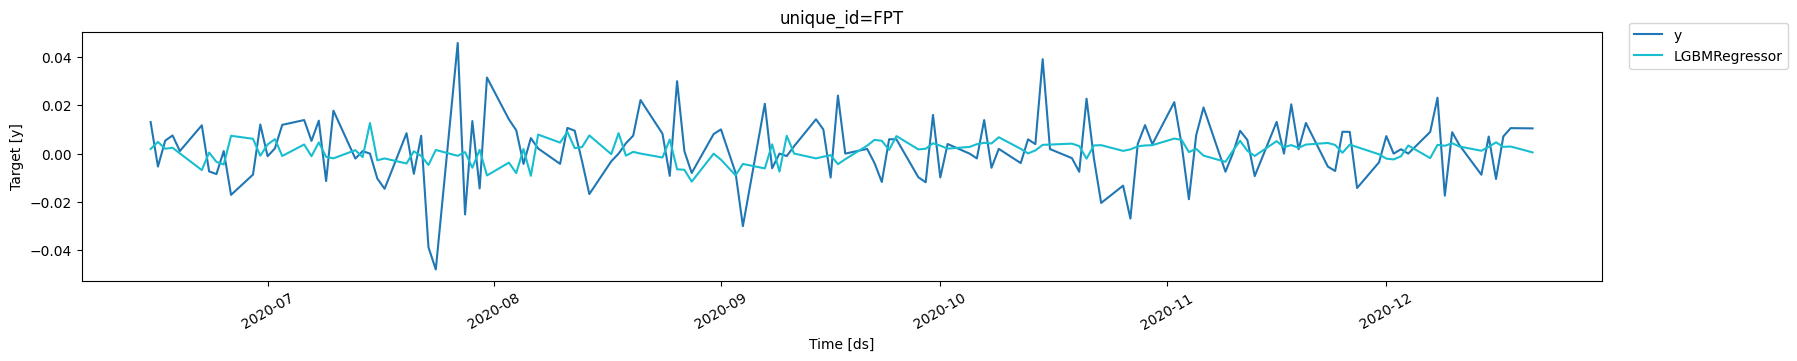

In [66]:
fig

In [ ]:
def evaluate_cv(df):
    return rmse(df, models=['LGBMRegressor'], id_col='cutoff').set_index('cutoff')

split_rmse = evaluate_cv(cv_result)
split_rmse

In [ ]:
model_params = {
    'verbose': 1,
    'learning_rate':0.01,
    'num_leaves': 256,
    'n_estimators': 50,
}

model_params = {
    'verbose': -1,
    'objective': 'regression',
    'metric': 'mae',  
    'boosting_type': 'gbdt',
    'learning_rate':0.01,
    'num_leaves': 256,
    'n_estimators': 50,
}

In [ ]:
params = {'n_estimators': 500,
          'num_leaves' : 100,
          'learning_rate': 0.1,
          'colsample_bytree': 0.9,
          'subsample': 0.8,
          'reg_alpha': 0.4,
          'metric': 'mae',
          'random_state': 21}

In [ ]:
df_input

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
X, y = np.array(df_process[feat_list]), np.array(df_process['y'])

# Split into train and test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
X_train.shape

In [ ]:
X_train.shape[0]

In [ ]:
X_train.shape[1]

In [ ]:
X_train.shape[2]

In [ ]:
y_train.shape

In [ ]:
X_test.shape

In [ ]:
daily_data = df_process.copy()

In [ ]:
daily_data.head()

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(daily_data[['y']])

In [ ]:
len(scaled_data)

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(daily_data[['Return']])

sequence_length = 10
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i])

In [ ]:
# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[0], X_train.shape[1])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

In [ ]:
X

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))